### 1. Data preprocessing

In [1]:
%matplotlib inline
plt.style.use('bmh')
# %matplotlib widget

# 1) read data
df = pd.read_csv('data/input.csv')
print(df.shape)

# 2) preprocessing
df.drop_duplicates(subset = ['CODI EOI','DATA','CONTAMINANT'], inplace = True)
print(df.shape)
dict_repl = {
    "Ribera d¿Ebre": "Ribera d'Ebre"
}
df['NOM COMARCA'] = df['NOM COMARCA'].map(lambda x: dict_repl[x] if x in dict_repl else x)
df['DATA'] = pd.to_datetime(df['DATA'], dayfirst = True)

df['year'] = df['DATA'].dt.year
df['month'] = df['DATA'].dt.month
df['weekday'] = df['DATA'].dt.dayofweek

# 3) features lists
feats10 = ['CODI EOI', 'CODI INE', 'CODI COMARCA', 'NOM ESTACIO', 'MUNICIPI', 'NOM COMARCA', 'ALTITUD']
feats11 = ['TIPUS ESTACIO', 'AREA URBANA', 'LATITUD','LONGITUD', 'GEOREFERENCIA']
feats2  = ['MAGNITUD', 'CONTAMINANT', 'UNITATS']

feat_dt     = ['DATA']
feats_vals  = ['01h','02h','03h','04h','05h','06h','07h','08h','09h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h','24h']

feats = feats10 + feats11 + feats2 + feat_dt + feats_vals

df[feats][:2]

(3106374, 40)
(3106373, 40)


,CODI EOI,CODI INE,CODI COMARCA,NOM ESTACIO,MUNICIPI,NOM COMARCA,ALTITUD,TIPUS ESTACIO,AREA URBANA,LATITUD,LONGITUD,GEOREFERENCIA,MAGNITUD,CONTAMINANT,UNITATS,DATA,01h,02h,03h,04h,05h,06h,07h,08h,09h,10h,11h,12h,13h,14h,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
0,43148003,43148,36,Tarragona (Bonavista),Tarragona,Tarragonès,39,industrial,suburban,41.12,1.19,POINT (1.1919986 41.11591),10,PM10,µg/m3,2023-01-25,11.00,9.00,12.00,12.00,11.00,12.00,15.00,18.00,19.00,24.00,22.00,22.00,28.00,24.00,17.00,22.00,18.00,24.00,28.00,29.00,39.00,33.00,24.00,20.00
1,8137001,8137,41,Montseny (La Castanya),Montseny,Vallès Oriental,693,background,rural,41.78,2.36,POINT (2.358002 41.77928),12,NOX,µg/m3,2023-01-25,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.00,2.00,1.00,NaN,NaN,NaN,3.00,14.00,9.00,4.00,3.00,3.00,3.00,2.00,2.00


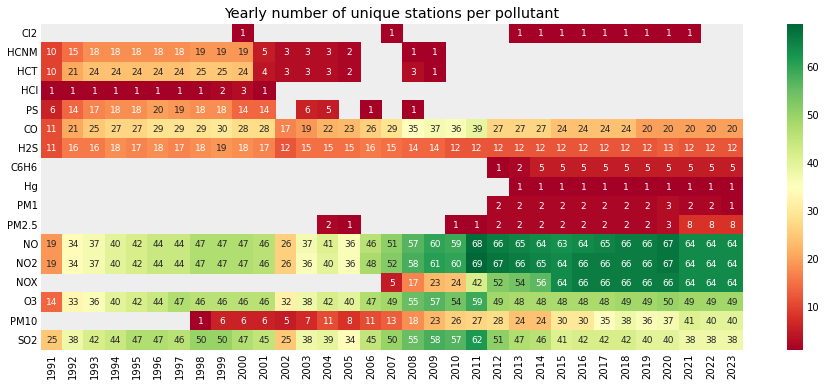

In [2]:
# 4) segmentation of pollutants
segm_old  = 'Cl2 HCNM HCT HCl PS'.split(' ')
segm_top  = 'NO NO2 NOX O3 PM10 SO2'.split(' ')
segm_rare = 'CO H2S C6H6 Hg PM1 PM2.5'.split(' ')

feats1 = ['CONTAMINANT','year']
df2 = df.groupby(feats1)['CODI EOI'].nunique().unstack()

df2 = df2.loc[segm_old+segm_rare+segm_top]
_, ax = plt.subplots(figsize = (14,6))
_ = sns.heatmap(df2, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.0f', annot_kws={"size": 9})
_ = ax.set_xlabel('')
_ = ax.set_ylabel('')
_ = ax.set_title('Yearly number of unique stations per pollutant')
plt.savefig(f'presentation/pictures/segementation.png', bbox_inches='tight')
plt.show()

### 2. Yearly trends

In [3]:
# yearly average of measurements
feats1 = ['year','CONTAMINANT']
df2 = df.groupby(feats1)[feats_vals].mean().mean(axis = 1).unstack()
df2.index = df2.index.astype(str)
df2 = df2[:-1]
df2['x'] = range(len(df2))

for f in df2.columns:
    df2.loc[df2[f] < 0, f] = np.nan

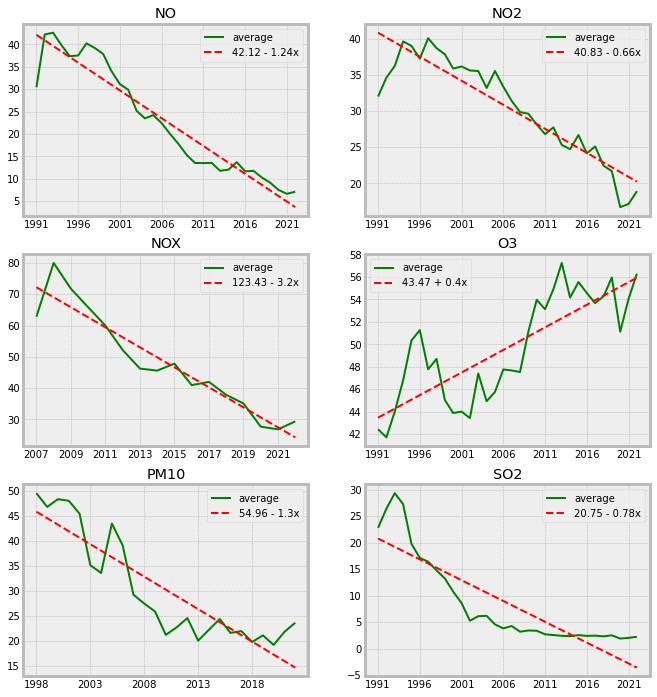

In [4]:
# plotting
FEATS = segm_top
COLOR = 'green'
TAG = 'yearly_top'

def plot_yearly(i,j,ind):
    feat = FEATS[j]
    y = df2[feat]
    # trend
    f1 = ~y.isnull()
    x = np.polyfit(df2.x[f1], y[f1], 1)
    p = np.poly1d(x)
    a1 = x[1].round(2)
    a2 = x[0].round(2)
    coef = f'{a1} - {-a2}x' if a2 < 0 else f'{a1} + {a2}x' 
    df2['Prediction'] = df2.x.map(p)
    # plot
    y[f1].plot(ax = ax[ind][i], title = feat, color = COLOR, xlabel = '')
    df2[f1].Prediction.plot(ax = ax[ind][i], title = feat, color = 'red', style = '--', xlabel = '')
    _ = ax[ind][i].legend(['average', coef])
    

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_yearly(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

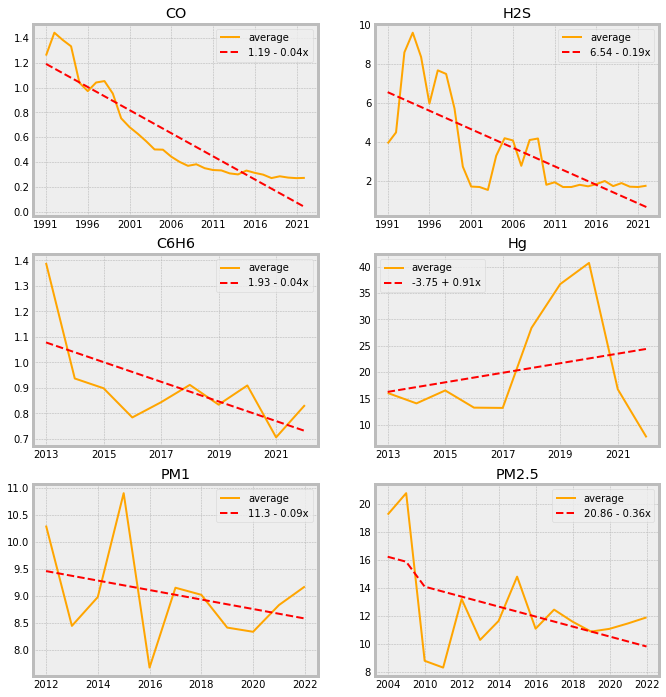

In [5]:
# plotting
FEATS = segm_rare
COLOR = 'orange'
TAG = 'yearly_rare'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_yearly(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

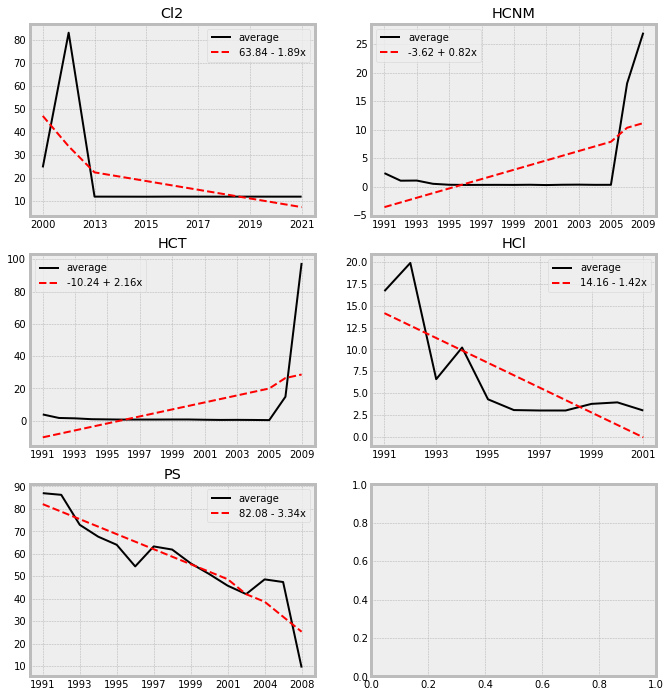

In [6]:
# plotting
FEATS = segm_old
COLOR = 'black'
TAG = 'yearly_old'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        if j == 5:
            break
        plot_yearly(i,j,ind)
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

### 3. Monthly seasonality

In [7]:
# monthly average or measurements
feats1 = ['month','CONTAMINANT']
filt = df.year >= 1990
df2 = df[filt].groupby(feats1)[feats_vals].mean().mean(axis = 1).unstack()

In [8]:
# plotting function
def plot_simple(i,j,ind, kind = 'line'):
    feat = FEATS[j]
    y = df2[feat]
    _ = y.plot(ax = ax[ind][i], title = feat, color = COLOR, xlabel = '', ylabel = '', kind = kind)

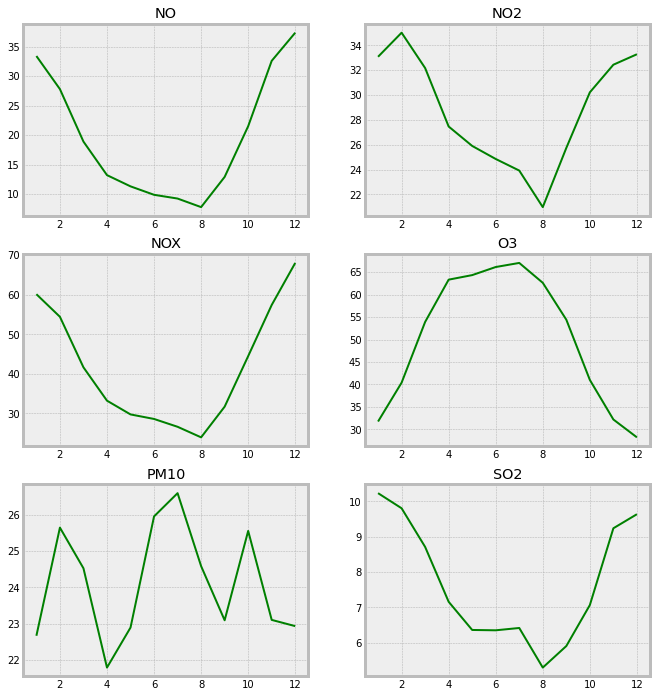

In [9]:
# plotting
FEATS = segm_top
COLOR = 'green'
TAG = 'monthly_top'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

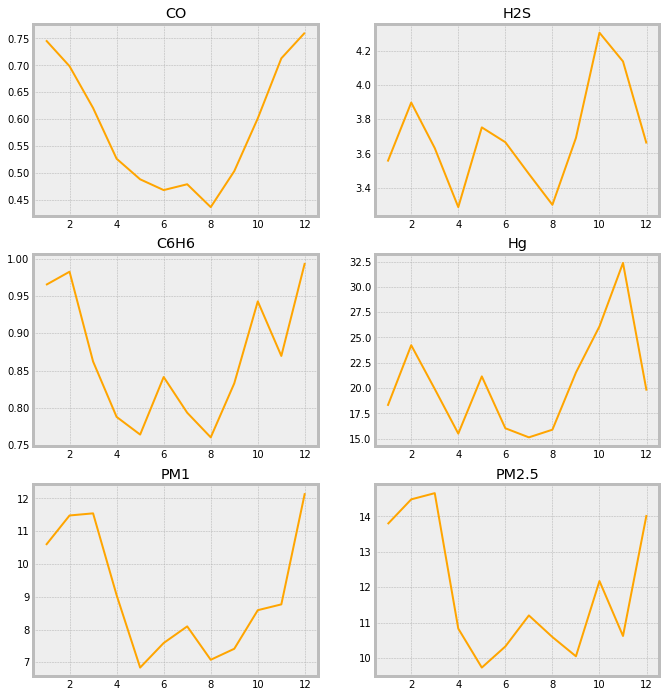

In [10]:
# plotting
FEATS = segm_rare
COLOR = 'orange'
TAG = 'monthly_rare'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

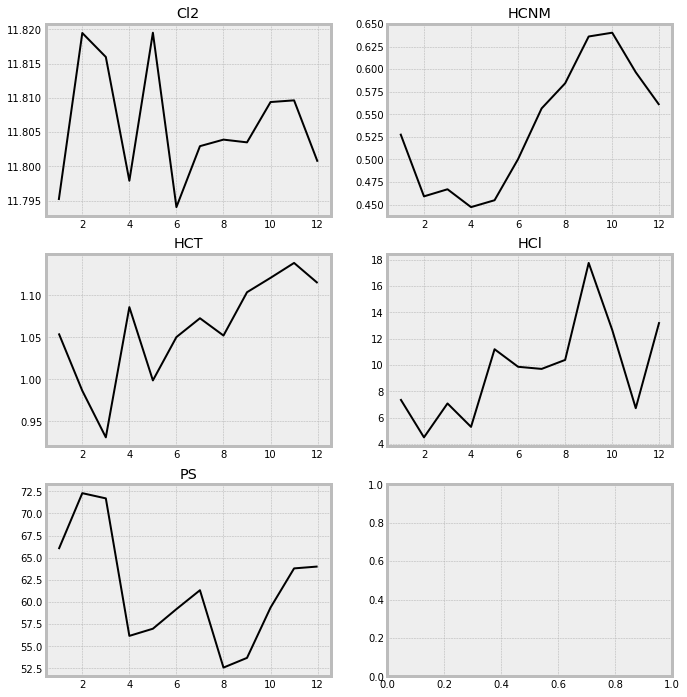

In [11]:
# plotting
FEATS = segm_old
COLOR = 'black'
TAG = 'monthly_old'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        if j == 5:
            break
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

### 4. Daily seasonality

In [12]:
# daily average or measurements
feats1 = ['CONTAMINANT']
filt = df.year >= 1990
df2 = df[filt].groupby(feats1)[feats_vals].mean().T

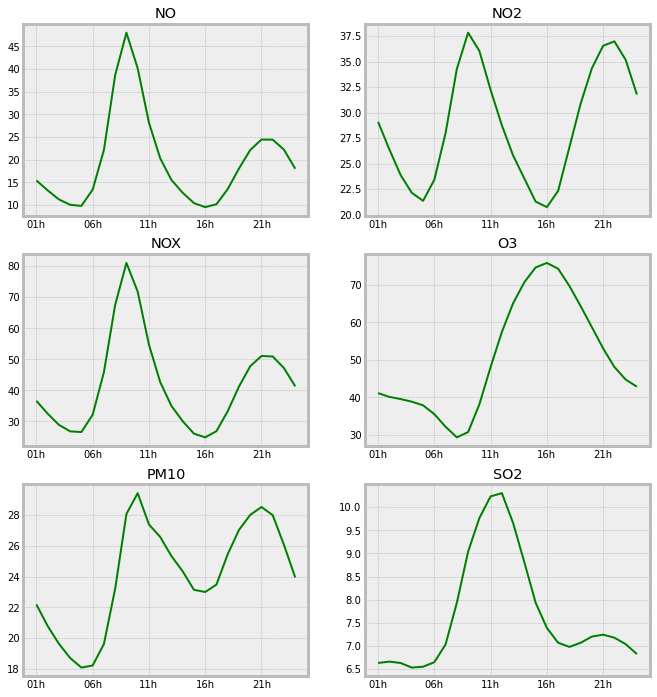

In [13]:
# plotting
FEATS = segm_top
COLOR = 'green'
TAG = 'daily_top'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

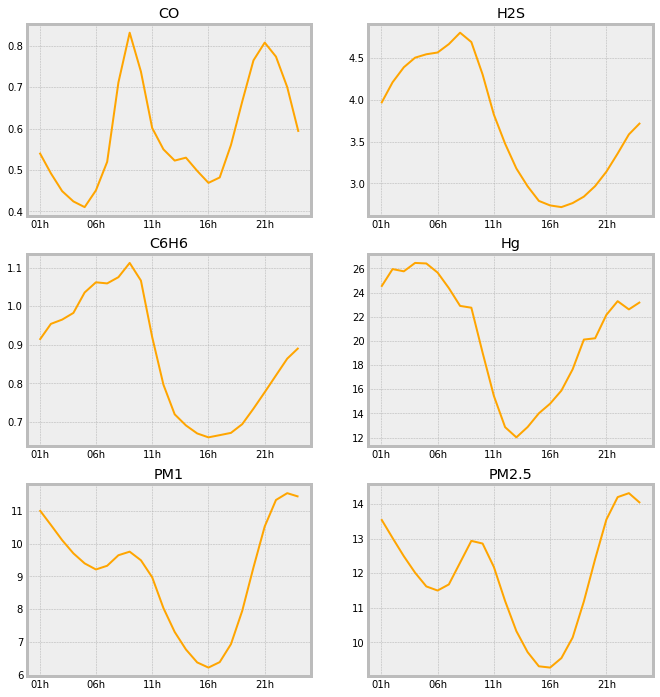

In [14]:
# plotting
FEATS = segm_rare
COLOR = 'orange'
TAG = 'daily_rare'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

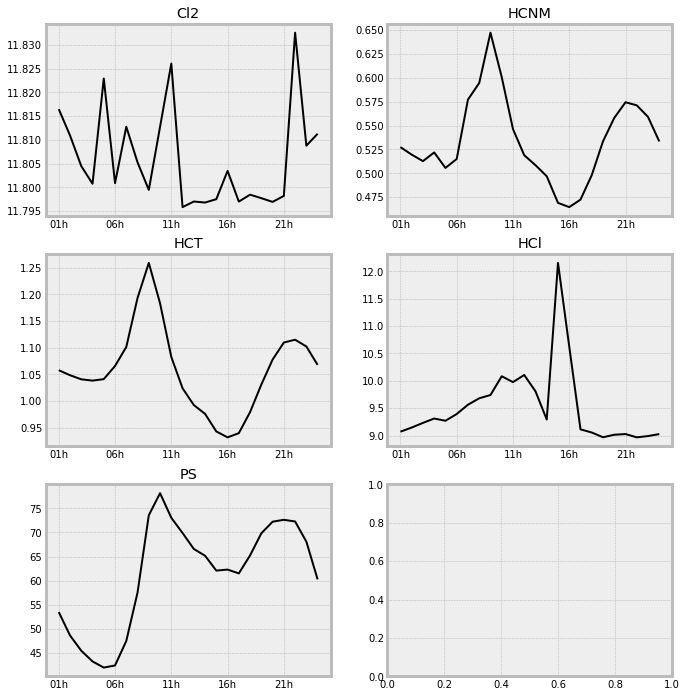

In [15]:
# plotting
FEATS = segm_old
COLOR = 'black'
TAG = 'daily_old'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2        
        if j == 5:
            break
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

### 5. Weekday seasonality

In [16]:
# weekday average or measurements
feats1 = ['weekday','CONTAMINANT']
filt = df.year >= 1990
df2 = df[filt].groupby(feats1)[feats_vals].mean().mean(axis = 1).unstack()

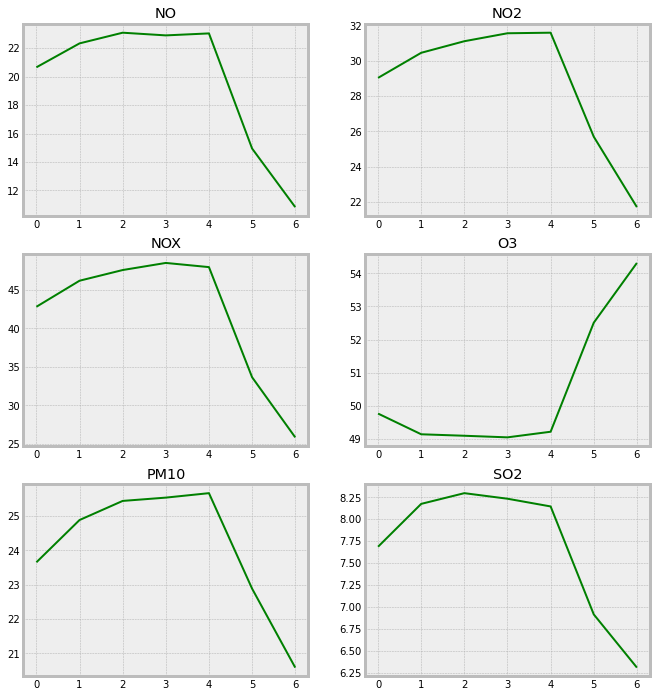

In [17]:
# plotting
FEATS = segm_top
COLOR = 'green'
TAG = 'weekday_top'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

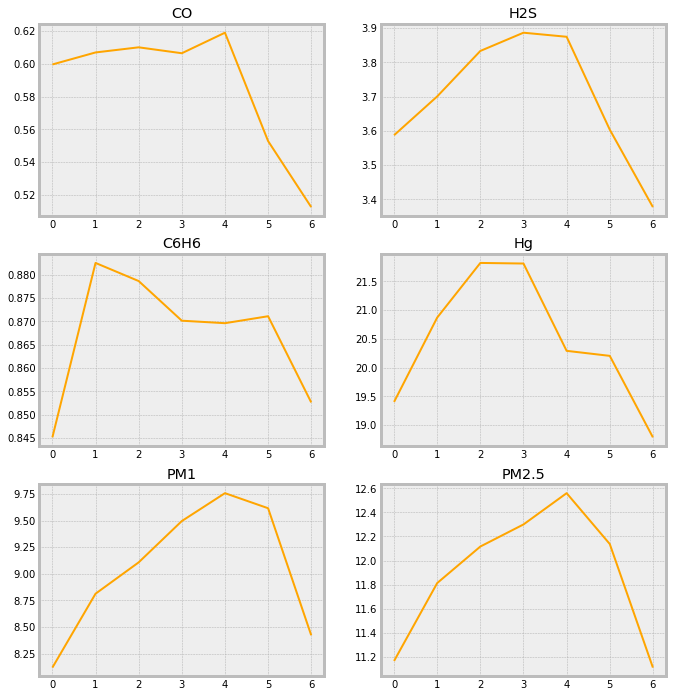

In [18]:
# plotting
FEATS = segm_rare
COLOR = 'orange'
TAG = 'weekday_rare'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

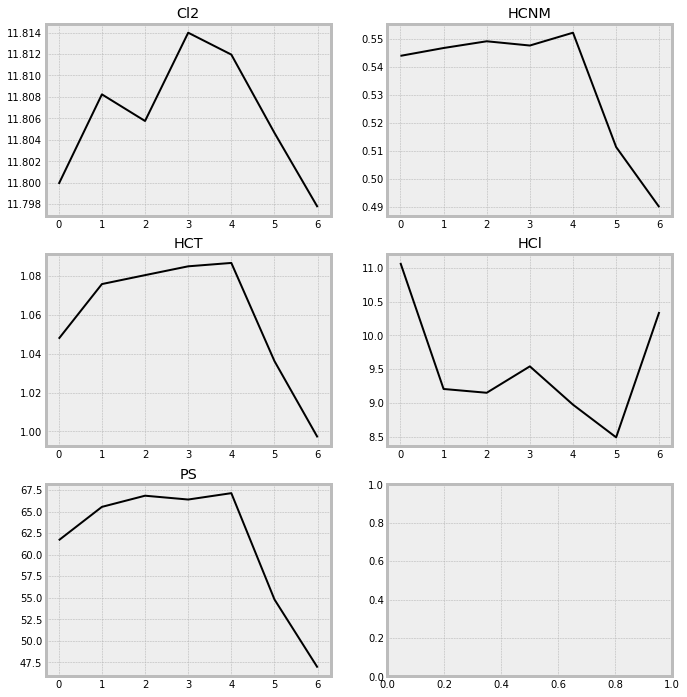

In [19]:
# plotting
FEATS = segm_old
COLOR = 'black'
TAG = 'weekday_old'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        if j == 5:
            break
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

### 6. AREA URBANA

In [20]:
feats1 = ['AREA URBANA', 'CONTAMINANT']
filt = df.year >= 1990
df2 = df[filt].groupby(feats1)[feats_vals].mean().mean(axis = 1).unstack()

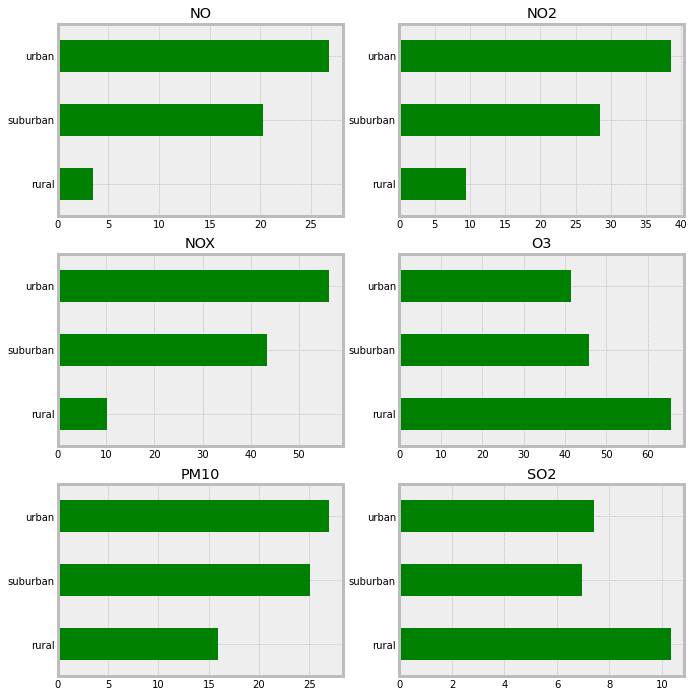

In [21]:
# plotting
FEATS = segm_top
COLOR = 'green'
TAG = 'urbana_top'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind, kind = 'barh') 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

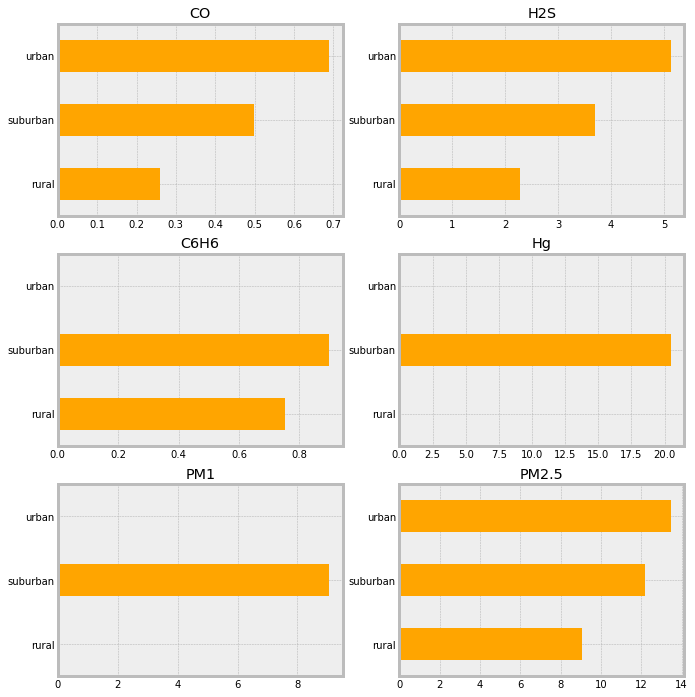

In [22]:
# plotting
FEATS = segm_rare
COLOR = 'orange'
TAG = 'urbana_rare'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind, kind = 'barh') 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

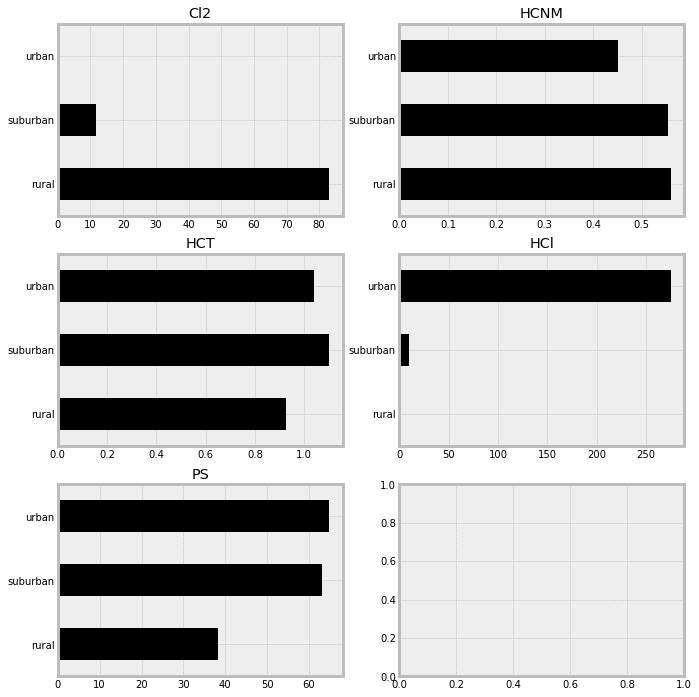

In [23]:
# plotting
FEATS = segm_old
COLOR = 'black'
TAG = 'urbana_old'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        if j == 5:
            break
        plot_simple(i,j,ind, kind = 'barh') 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

### 7. ALTITUD

In [31]:
bins = [-np.inf, 0.33, 0.66, np.inf]

df['att_rank'] = df.groupby('CONTAMINANT')['ALTITUD'].rank(pct = True)
df['att_group'] = pd.cut(df['att_rank'], bins = bins, labels = range(len(bins)-1))

feats1 = ['att_group', 'CONTAMINANT']
filt = df.year >= 1990

# number of rows in the groups
df2 = df[filt].groupby(feats1).size().unstack()
print(df2.shape)
df2[:5]

(3, 17)


CONTAMINANT,C6H6,CO,Cl2,H2S,HCNM,HCT,HCl,Hg,NO,NO2,NOX,O3,PM1,PM10,PM2.5,PS,SO2
att_group,,,,,,,,,,,,,,,,,
0,6039,87038,1,48275,17362,22556,4,0,179448,178032,89293,163862,589,54677,4714,18853,149988
1,3003,86725,3012,48693,16029,20716,1724,3577,184151,183532,89248,151358,3393,58189,3602,18000,147616
2,6990,92990,1,50654,16406,22032,0,0,182932,185678,94759,171581,2890,57417,3108,20386,155250


In [32]:
# average values in the groups
df2 = df[filt].groupby(feats1)[feats_vals].mean().mean(axis = 1).unstack()
print(df2.shape)
df2

(3, 17)


CONTAMINANT,C6H6,CO,Cl2,H2S,HCNM,HCT,HCl,Hg,NO,NO2,NOX,O3,PM1,PM10,PM2.5,PS,SO2
att_group,,,,,,,,,,,,,,,,,
0,0.66,0.59,24.50,5.19,0.58,1.10,207.63,NaN,20.44,33.40,46.09,44.93,9.05,29.86,11.17,59.84,6.33
1,0.64,0.64,11.80,3.56,0.62,1.17,9.31,20.46,21.26,29.80,48.45,46.69,8.38,23.34,12.88,57.02,6.43
2,1.14,0.54,83.00,2.39,0.40,0.92,NaN,NaN,17.32,23.18,31.34,58.97,9.88,19.31,11.79,66.64,10.17


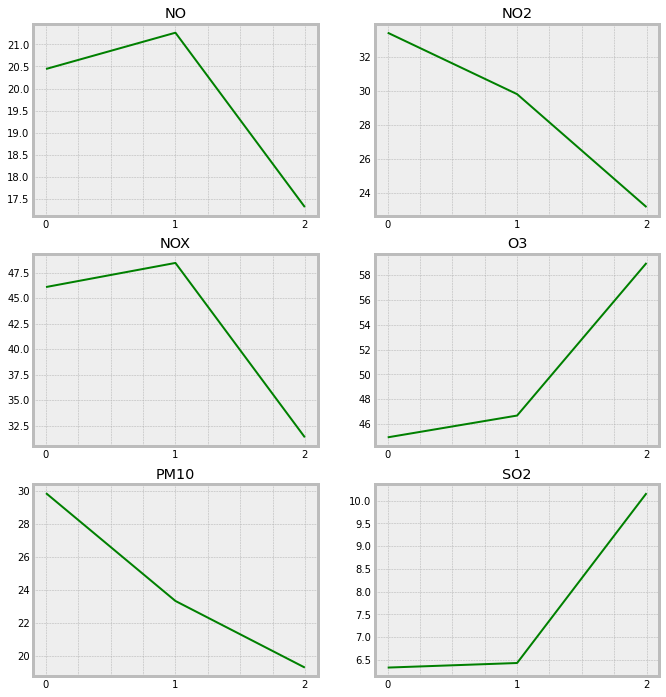

In [33]:
# plotting
FEATS = segm_top
COLOR = 'green'
TAG = 'altitud_top'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

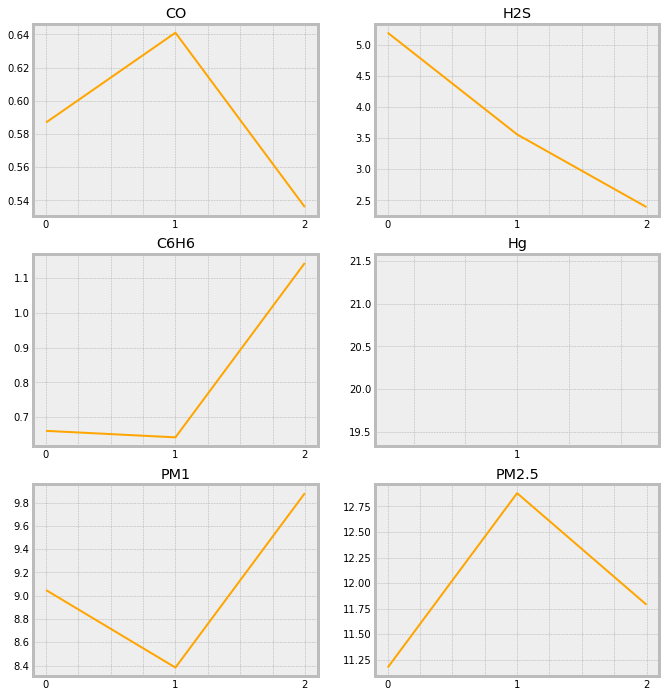

In [34]:
# plotting
FEATS = segm_rare
COLOR = 'orange'
TAG = 'altitud_rare'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

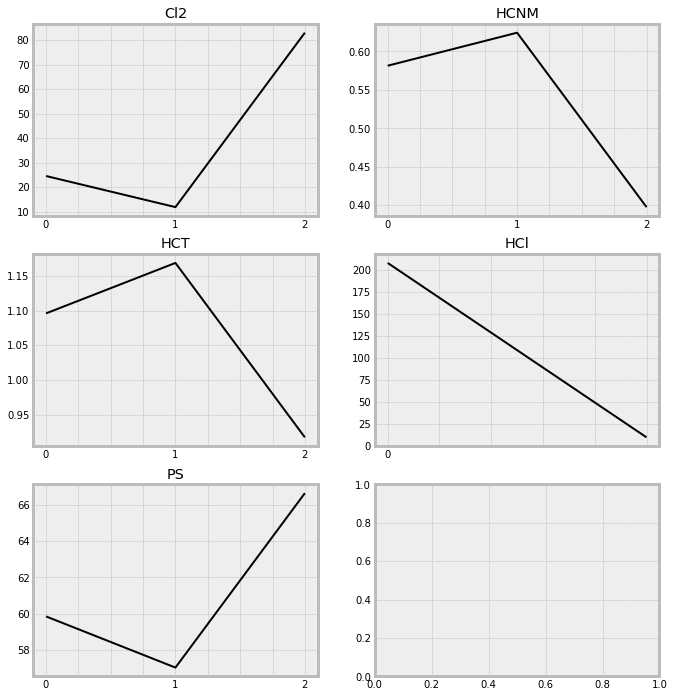

In [35]:
# plotting
FEATS = segm_old
COLOR = 'black'
TAG = 'altitud_old'

_, ax = plt.subplots(3,2, figsize = (10,12))
for ind in range(3):
    for i in range(2):
        j=i+ind*2
        if j == 5:
            break
        plot_simple(i,j,ind) 
plt.savefig(f'presentation/pictures/{TAG}.png', bbox_inches='tight')
plt.show()

### 8. Countries ratings

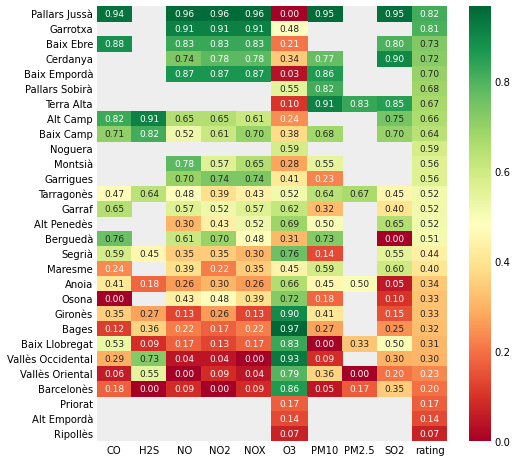

In [29]:
# 1) Create rankings
feats1 = ['NOM COMARCA','CONTAMINANT']
year_min = 1990 # 2022 2018 2013 1990
f1 = df.year >= year_min
f2 = df.CONTAMINANT.isin(segm_top+segm_rare)
f3 = ~df.CONTAMINANT.isin(['C6H6','Hg','PM1'])

df2 = df[f1&f2&f3].groupby(feats1)[feats_vals].mean().mean(axis = 1).unstack()

df2 = df2.rank(pct = True)
df2 = 1 - df2
df2['rating'] = df2.mean(axis = 1)
df2.sort_values('rating', ascending = False, inplace = True)


_, ax = plt.subplots(figsize = (7,8))
_ = sns.heatmap(df2, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.2f', annot_kws={"size": 9})
_ = ax.set_xlabel('')
_ = ax.set_ylabel('')
# _ = ax.set_title('Countries ratings')
plt.savefig(f'presentation/pictures/rankings1_{year_min}.png', bbox_inches='tight')
plt.show()

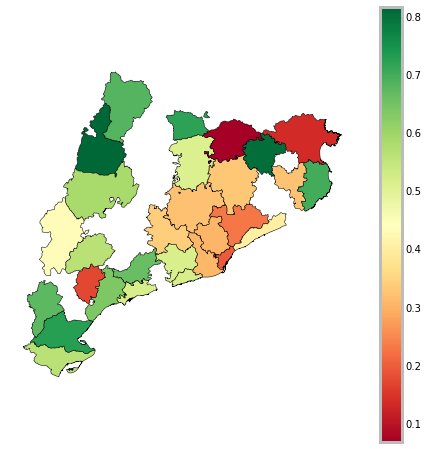

In [30]:
# 2) Merge with shape file
import geopandas as gpd

file1 = 'data/geo/shapefiles_catalunya_comarcas.shp'
df_shape = gpd.read_file(file1)

# print(df_shape.shape)
# display(df_shape[:3])

# _ = df_shape.plot(figsize=(7,7), edgecolor="black", k = 5, legend = 'True', cmap = 'RdYlGn', )
# _ = plt.axis('off')

df_shape1 = df_shape[['nom_comar','geometry','provincia']].rename(columns = {'nom_comar':'NOM COMARCA'})
df3 = df_shape1.merge(df2.reset_index(), how= 'left')[['geometry','NOM COMARCA','rating','provincia']]
# print(df3[df3.geometry.isnull()].shape)
# print(df3.shape)
# df3[:4]

# plotting
_, ax = plt.subplots(1,1, figsize = (7,8))
_ = df3.plot(ax = ax, edgecolor="black", column = 'rating', k = 5, legend = True, cmap = 'RdYlGn')
# _ = ax.set_title(f'from year = {year_min}')
_ = plt.axis('off')
plt.savefig(f'presentation/pictures/rankings2_{year_min}.png', bbox_inches='tight')
plt.show()